In [1]:
import numpy as np
import torch
import torch.nn as nn
import csv
import os
import cv2
from PIL import Image
from enduro_lstm import *
import matplotlib.pyplot as plt
import time

In [2]:
use_gpu = input("Use GPU (y/n) ")
if use_gpu == 'y':
    use_gpu = True
else:
    use_gpu = False

device = conf_cuda(use_gpu)

if use_gpu:
    torch.cuda.empty_cache()

Use GPU (y/n) y
GPU is available


In [3]:
path = "models/continue_m45to50_f1to1000_epoch10001to20000_H200/"
model_path = path + "continue_m45to50_f1to1000_epoch10001to20000_H200"

In [5]:
start_match = 45
end_match = 50

start_frame = 1
end_frame = 1000

output_size = 9
hidden_neurons = 200

n_epochs = 10000

In [6]:
data_path = r"../1-generate/data/"
obs = "continue"

In [7]:
if obs == 'zigzag':
    zigzag = True
else:
    zigzag = False
zigzag

False

In [8]:
train_loss_arr = np.load(path + 'train_loss_arr.npz')
valid_loss_arr = np.load(path + 'valid_loss_arr.npz')
valid_loss_mean_arr = np.load(path + 'valid_loss_mean_arr.npz')

train_loss_arr = train_loss_arr.f.arr_0
valid_loss_arr = valid_loss_arr.f.arr_0
valid_loss_mean_arr = valid_loss_mean_arr.f.arr_0

print("Successfully loaded NPZ.")

Successfully loaded NPZ.


In [9]:
def load_checkpoint(model, optimizer, filename):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer = torch.optim.Adam(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer'])
        losslogger = checkpoint['losslogger']
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch, losslogger

In [10]:
model = Model(device=device, input_size=20400, output_size=output_size, hidden_dim=hidden_neurons, n_layers=1)
min_loss = 1e-05
# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [11]:
model, optimizer, start_epoch, losslogger = load_checkpoint(model, optimizer, filename=model_path)

=> loading checkpoint 'models/continue_m45to50_f1to1000_epoch10001to20000_H200/continue_m45to50_f1to1000_epoch10001to20000_H200'
=> loaded checkpoint 'models/continue_m45to50_f1to1000_epoch10001to20000_H200/continue_m45to50_f1to1000_epoch10001to20000_H200' (epoch 20001)


In [12]:
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [13]:
if use_gpu:
    optimizer_to(optimizer, device)

In [14]:
model_name = f"{obs}_m{start_match}to{end_match}_f{start_frame}to{end_frame}_epoch{start_epoch}to{start_epoch + n_epochs - 1}_H{hidden_neurons}"
newpath = f"models/" + model_name
if not os.path.exists(newpath):
    print(f"models/" + model_name + " created")
    os.makedirs(newpath)
else:
    print(f"models/" + model_name)
    print("ATTENTION! folder not created. Training informations will overwrite the existing one")

models/continue_m45to50_f1to1000_epoch20001to30000_H200
ATTENTION! folder not created. Training informations will overwrite the existing one


data

In [15]:
ACTIONS_LIST = get_actions_list(zigzag=False)

In [16]:
num_of_frames_arr = []
frames_arr = []
actions_arr = []

In [17]:
for m in range(start_match, end_match + 1):
    
    num_of_frames, frames, actions, rewards, lifes = load_npz(data_path, m)
    frames = frames[start_frame - 1:end_frame]
    actions = actions[start_frame - 1:end_frame]
    
    action_one_hot = [prepare_action_data(i, ACTIONS_LIST) for i in actions]
    actions = np.array(action_one_hot)
    actions = actions.reshape(len(actions), -1)
    
    frames_arr.append(frames)
    actions_arr.append(actions)
    num_of_frames_arr.append(end_frame - start_frame + 1) 

Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.
Successfully loaded NPZ.


In [18]:
X_train = np.array(frames_arr)/255
Y_train = np.array(actions_arr)
num_of_frames_arr = np.array(num_of_frames_arr)

X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

In [19]:
# We'll also set the model to the device that we defined earlier (default is CPU)
if use_gpu:
    print("Use GPU")
    model.cuda()
    X_train = X_train.cuda() 
    Y_train = Y_train.cuda()

Use GPU


In [20]:
# Training Run
loss_file = open(newpath + '/' + "loss_file.txt", "w")
first_epoch = True

In [21]:
best_loss = losslogger
train_acc_arr = np.array([])
valid_acc_arr = np.array([])
valid_acc_mean_arr = np.array([])

In [22]:
start_time_processing = time.time()
for epoch in range(start_epoch, start_epoch + n_epochs):

    model.train()

    optimizer.zero_grad() # Clears existing gradients from previous epoch
    X_train.to(device)
    output, hidden = model(X_train)
    loss = criterion(output, Y_train.view(-1,len(ACTIONS_LIST)).float())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
        
    if epoch%10 == 0:

        train_loss_arr = np.append(train_loss_arr, loss.item())
        train_acc_arr  = np.append(train_acc_arr, get_acc(output, Y_train.reshape(-1, len(ACTIONS_LIST))))
    
        model.eval()
        
        epoch_valid_losses = np.array([])
        epoch_valid_acc = np.array([])
        for seq in range(len(X_train)):
            output, hidden = model(torch.unsqueeze(X_train[seq], 1))
            loss = criterion(output, Y_train[seq].view(-1,len(ACTIONS_LIST)).float())
            epoch_valid_losses = np.append(epoch_valid_losses, loss.item())
            epoch_valid_acc = np.append( epoch_valid_acc, get_acc(output, Y_train[seq].reshape(-1, len(ACTIONS_LIST))) )
            
        if first_epoch:
            # valid_loss_arr = epoch_valid_losses.reshape(-1, 1)
            valid_loss_arr = np.insert(valid_loss_arr, valid_loss_arr.shape[1], epoch_valid_losses, axis=1)
            
            valid_acc_arr = epoch_valid_acc.reshape(-1, 1)
            first_epoch = False
        else:
            valid_loss_arr = np.insert(valid_loss_arr, valid_loss_arr.shape[1], epoch_valid_losses, axis=1)
            valid_acc_arr = np.insert(valid_acc_arr, valid_acc_arr.shape[1], epoch_valid_acc, axis=1)
            
        valid_loss_mean_arr = np.append(valid_loss_mean_arr, np.mean(epoch_valid_losses))
        valid_acc_mean_arr = np.append(valid_acc_mean_arr, np.mean(epoch_valid_acc))
            
        valid_loss_mean_arr = np.append(valid_loss_mean_arr, np.mean(epoch_valid_losses))
        valid_acc_mean_arr = np.append(valid_acc_mean_arr, np.mean(epoch_valid_acc))
        
        loss_file.write("Epoch: {}/{}-------------------------------------------\n".format(epoch, start_epoch + n_epochs - 1))
        loss_file.write("Train -> Loss: {:.15f} Acc: {:.15f}\n".format(train_loss_arr[-1], train_acc_arr[-1]))
        loss_file.write("Valid -> Loss: {:.15f} Acc: {:.15f}\n".format(valid_loss_mean_arr[-1], valid_acc_mean_arr[-1]))
            
        print("Epoch: {}/{}-------------------------------------------".format(epoch, start_epoch + n_epochs - 1))
        print("Train -> Loss: {:.15f} Acc: {:.15f}".format(train_loss_arr[-1], train_acc_arr[-1]))
        print("Valid -> Loss: {:.15f} Acc: {:.15f}".format(valid_loss_mean_arr[-1], valid_acc_mean_arr[-1]))
        
        if train_loss_arr[-1] < best_loss:
            state = { 'epoch': epoch + 1, 'state_dict': model.state_dict(),
                      'optimizer': optimizer.state_dict(), 'losslogger': loss.item(), }
            torch.save(state, newpath + '/' + model_name)
            best_loss = loss.item()
        
        if (valid_loss_mean_arr[-1] < min_loss):
            break

loss_file.close()
np.savez(newpath + '/' + "train_loss_arr", train_loss_arr)
np.savez(newpath + '/' + "valid_loss_arr", valid_loss_arr)
np.savez(newpath + '/' + "valid_loss_mean_arr", valid_loss_mean_arr)
print("--- %s seconds ---" % (time.time() - start_time_processing))

Epoch: 20010/30000-------------------------------------------
Train -> Loss: 0.029002876952291 Acc: 0.809333324432373
Valid -> Loss: 0.060422154764334 Acc: 0.587166696786880
Epoch: 20020/30000-------------------------------------------
Train -> Loss: 0.028994610533118 Acc: 0.809333324432373
Valid -> Loss: 0.060581749926011 Acc: 0.586000025272369
Epoch: 20030/30000-------------------------------------------
Train -> Loss: 0.028988655656576 Acc: 0.809499979019165
Valid -> Loss: 0.060583709428708 Acc: 0.586000025272369
Epoch: 20040/30000-------------------------------------------
Train -> Loss: 0.028983246535063 Acc: 0.809666633605957
Valid -> Loss: 0.060609330112735 Acc: 0.586166689793269
Epoch: 20050/30000-------------------------------------------
Train -> Loss: 0.028978085145354 Acc: 0.810000002384186
Valid -> Loss: 0.060618019352357 Acc: 0.585833360751470
Epoch: 20060/30000-------------------------------------------
Train -> Loss: 0.028973164036870 Acc: 0.810000002384186
Valid -> Los

Epoch: 20490/30000-------------------------------------------
Train -> Loss: 0.028827587142587 Acc: 0.811333298683167
Valid -> Loss: 0.060787774001559 Acc: 0.582833369572957
Epoch: 20500/30000-------------------------------------------
Train -> Loss: 0.028822598978877 Acc: 0.811666667461395
Valid -> Loss: 0.060799886162082 Acc: 0.582166701555252
Epoch: 20510/30000-------------------------------------------
Train -> Loss: 0.028817707672715 Acc: 0.811666667461395
Valid -> Loss: 0.060813358674447 Acc: 0.582166701555252
Epoch: 20520/30000-------------------------------------------
Train -> Loss: 0.028812894597650 Acc: 0.811666667461395
Valid -> Loss: 0.060825451587637 Acc: 0.582000037034353
Epoch: 20530/30000-------------------------------------------
Train -> Loss: 0.028808141127229 Acc: 0.811999976634979
Valid -> Loss: 0.060838688785831 Acc: 0.582000037034353
Epoch: 20540/30000-------------------------------------------
Train -> Loss: 0.028803424909711 Acc: 0.812166631221771
Valid -> Los

Epoch: 20970/30000-------------------------------------------
Train -> Loss: 0.030422756448388 Acc: 0.802999973297119
Valid -> Loss: 0.060169967512290 Acc: 0.585666696230570
Epoch: 20980/30000-------------------------------------------
Train -> Loss: 0.029966836795211 Acc: 0.806500017642975
Valid -> Loss: 0.062142884979645 Acc: 0.572166691223780
Epoch: 20990/30000-------------------------------------------
Train -> Loss: 0.029161386191845 Acc: 0.815333306789398
Valid -> Loss: 0.058607066671054 Acc: 0.599500030279160
Epoch: 21000/30000-------------------------------------------
Train -> Loss: 0.028701923787594 Acc: 0.812166631221771
Valid -> Loss: 0.061034992337227 Acc: 0.580666691064835
Epoch: 21010/30000-------------------------------------------
Train -> Loss: 0.028717685490847 Acc: 0.812833309173584
Valid -> Loss: 0.060801657537619 Acc: 0.583833346764247
Epoch: 21020/30000-------------------------------------------
Train -> Loss: 0.028649851679802 Acc: 0.813166677951813
Valid -> Los

Epoch: 21450/30000-------------------------------------------
Train -> Loss: 0.029418736696243 Acc: 0.804833352565765
Valid -> Loss: 0.060165576636791 Acc: 0.585833360751470
Epoch: 21460/30000-------------------------------------------
Train -> Loss: 0.029804183170199 Acc: 0.808666646480560
Valid -> Loss: 0.061152133469780 Acc: 0.578500012556712
Epoch: 21470/30000-------------------------------------------
Train -> Loss: 0.028902908787131 Acc: 0.814000010490417
Valid -> Loss: 0.058112341910601 Acc: 0.608500023682912
Epoch: 21480/30000-------------------------------------------
Train -> Loss: 0.028600472956896 Acc: 0.816166639328003
Valid -> Loss: 0.062792939444383 Acc: 0.564833362897237
Epoch: 21490/30000-------------------------------------------
Train -> Loss: 0.029764154925942 Acc: 0.812999963760376
Valid -> Loss: 0.057053677737713 Acc: 0.614666700363159
Epoch: 21500/30000-------------------------------------------
Train -> Loss: 0.029129263013601 Acc: 0.807999968528748
Valid -> Los

Epoch: 21930/30000-------------------------------------------
Train -> Loss: 0.032487206161022 Acc: 0.790833353996277
Valid -> Loss: 0.064153976738453 Acc: 0.575833360354106
Epoch: 21940/30000-------------------------------------------
Train -> Loss: 0.030033789575100 Acc: 0.812999963760376
Valid -> Loss: 0.060031333938241 Acc: 0.595000028610229
Epoch: 21950/30000-------------------------------------------
Train -> Loss: 0.029039464890957 Acc: 0.821500003337860
Valid -> Loss: 0.060890541722377 Acc: 0.582833369572957
Epoch: 21960/30000-------------------------------------------
Train -> Loss: 0.028684439137578 Acc: 0.814499974250793
Valid -> Loss: 0.059746683885654 Acc: 0.592666695515315
Epoch: 21970/30000-------------------------------------------
Train -> Loss: 0.028480172157288 Acc: 0.813499987125397
Valid -> Loss: 0.059609344229102 Acc: 0.594333360592524
Epoch: 21980/30000-------------------------------------------
Train -> Loss: 0.028422728180885 Acc: 0.819833338260651
Valid -> Los

Epoch: 22410/30000-------------------------------------------
Train -> Loss: 0.029744949191809 Acc: 0.809166669845581
Valid -> Loss: 0.066008307039738 Acc: 0.533833359678586
Epoch: 22420/30000-------------------------------------------
Train -> Loss: 0.028448905795813 Acc: 0.820333302021027
Valid -> Loss: 0.060865012928843 Acc: 0.581333359082540
Epoch: 22430/30000-------------------------------------------
Train -> Loss: 0.028361849486828 Acc: 0.821333348751068
Valid -> Loss: 0.060553851847847 Acc: 0.586000025272369
Epoch: 22440/30000-------------------------------------------
Train -> Loss: 0.028199579566717 Acc: 0.819499969482422
Valid -> Loss: 0.061133178571860 Acc: 0.583000024159749
Epoch: 22450/30000-------------------------------------------
Train -> Loss: 0.028166422620416 Acc: 0.820500016212463
Valid -> Loss: 0.060774857178330 Acc: 0.586500028769175
Epoch: 22460/30000-------------------------------------------
Train -> Loss: 0.028157226741314 Acc: 0.819833338260651
Valid -> Los

Epoch: 22890/30000-------------------------------------------
Train -> Loss: 0.028302112594247 Acc: 0.818666636943817
Valid -> Loss: 0.058483587577939 Acc: 0.606833368539810
Epoch: 22900/30000-------------------------------------------
Train -> Loss: 0.029381560161710 Acc: 0.807999968528748
Valid -> Loss: 0.058145307625333 Acc: 0.606500029563904
Epoch: 22910/30000-------------------------------------------
Train -> Loss: 0.028064403682947 Acc: 0.825500011444092
Valid -> Loss: 0.058770516887307 Acc: 0.605833361546198
Epoch: 22920/30000-------------------------------------------
Train -> Loss: 0.028641907498240 Acc: 0.816999971866608
Valid -> Loss: 0.062934567530950 Acc: 0.562500019868215
Epoch: 22930/30000-------------------------------------------
Train -> Loss: 0.028077794238925 Acc: 0.824999988079071
Valid -> Loss: 0.059587055817246 Acc: 0.598333368698756
Epoch: 22940/30000-------------------------------------------
Train -> Loss: 0.028126105666161 Acc: 0.819666683673859
Valid -> Los

Epoch: 23370/30000-------------------------------------------
Train -> Loss: 0.027904363349080 Acc: 0.824000000953674
Valid -> Loss: 0.060535978525877 Acc: 0.586333364248276
Epoch: 23380/30000-------------------------------------------
Train -> Loss: 0.027900479733944 Acc: 0.824166655540466
Valid -> Loss: 0.060546151672800 Acc: 0.585500021775564
Epoch: 23390/30000-------------------------------------------
Train -> Loss: 0.027896657586098 Acc: 0.824000000953674
Valid -> Loss: 0.060559422398607 Acc: 0.585500021775564
Epoch: 23400/30000-------------------------------------------
Train -> Loss: 0.027892889454961 Acc: 0.824499964714050
Valid -> Loss: 0.060570346812407 Acc: 0.585333357254664
Epoch: 23410/30000-------------------------------------------
Train -> Loss: 0.027889164164662 Acc: 0.824666678905487
Valid -> Loss: 0.060582137356202 Acc: 0.585666686296463
Epoch: 23420/30000-------------------------------------------
Train -> Loss: 0.027885474264622 Acc: 0.825166642665863
Valid -> Los

Epoch: 23850/30000-------------------------------------------
Train -> Loss: 0.027880413457751 Acc: 0.822166681289673
Valid -> Loss: 0.060096176962058 Acc: 0.590166697899500
Epoch: 23860/30000-------------------------------------------
Train -> Loss: 0.027831515297294 Acc: 0.826166629791260
Valid -> Loss: 0.060162287826339 Acc: 0.589833358923594
Epoch: 23870/30000-------------------------------------------
Train -> Loss: 0.027799401432276 Acc: 0.824499964714050
Valid -> Loss: 0.060161927094062 Acc: 0.590500017007192
Epoch: 23880/30000-------------------------------------------
Train -> Loss: 0.027776647359133 Acc: 0.826166629791260
Valid -> Loss: 0.060495334366957 Acc: 0.588166693846385
Epoch: 23890/30000-------------------------------------------
Train -> Loss: 0.027768628671765 Acc: 0.826166629791260
Valid -> Loss: 0.060366054996848 Acc: 0.589500029881795
Epoch: 23900/30000-------------------------------------------
Train -> Loss: 0.027761828154325 Acc: 0.825999975204468
Valid -> Los

Epoch: 24330/30000-------------------------------------------
Train -> Loss: 0.027677604928613 Acc: 0.827166676521301
Valid -> Loss: 0.061055640379588 Acc: 0.583166698614756
Epoch: 24340/30000-------------------------------------------
Train -> Loss: 0.027661183848977 Acc: 0.826999962329865
Valid -> Loss: 0.060691048701604 Acc: 0.586166699727376
Epoch: 24350/30000-------------------------------------------
Train -> Loss: 0.027654591947794 Acc: 0.827333331108093
Valid -> Loss: 0.060479467734694 Acc: 0.588666697343191
Epoch: 24360/30000-------------------------------------------
Train -> Loss: 0.027650738134980 Acc: 0.827166676521301
Valid -> Loss: 0.060328798989455 Acc: 0.589833368857702
Epoch: 24370/30000-------------------------------------------
Train -> Loss: 0.027642425149679 Acc: 0.827166676521301
Valid -> Loss: 0.060482396433751 Acc: 0.588833351929983
Epoch: 24380/30000-------------------------------------------
Train -> Loss: 0.027638241648674 Acc: 0.827166676521301
Valid -> Los

Epoch: 24810/30000-------------------------------------------
Train -> Loss: 0.027542140334845 Acc: 0.829333305358887
Valid -> Loss: 0.060291859010855 Acc: 0.589500019947688
Epoch: 24820/30000-------------------------------------------
Train -> Loss: 0.027538627386093 Acc: 0.829500019550323
Valid -> Loss: 0.060307403405507 Acc: 0.589333345492681
Epoch: 24830/30000-------------------------------------------
Train -> Loss: 0.027535164728761 Acc: 0.829666674137115
Valid -> Loss: 0.060323078806202 Acc: 0.589166680971781
Epoch: 24840/30000-------------------------------------------
Train -> Loss: 0.027531746774912 Acc: 0.829833328723907
Valid -> Loss: 0.060338467359543 Acc: 0.589333345492681
Epoch: 24850/30000-------------------------------------------
Train -> Loss: 0.027528360486031 Acc: 0.829833328723907
Valid -> Loss: 0.060352097575863 Acc: 0.589166680971781
Epoch: 24860/30000-------------------------------------------
Train -> Loss: 0.027525007724762 Acc: 0.829833328723907
Valid -> Los

Epoch: 25290/30000-------------------------------------------
Train -> Loss: 0.027433685958385 Acc: 0.831166684627533
Valid -> Loss: 0.060295890395840 Acc: 0.591333349545797
Epoch: 25300/30000-------------------------------------------
Train -> Loss: 0.027470901608467 Acc: 0.829166650772095
Valid -> Loss: 0.059832215930025 Acc: 0.594666699568431
Epoch: 25310/30000-------------------------------------------
Train -> Loss: 0.027660122141242 Acc: 0.828499972820282
Valid -> Loss: 0.059297167385618 Acc: 0.597000032663345
Epoch: 25320/30000-------------------------------------------
Train -> Loss: 0.036185827106237 Acc: 0.762666642665863
Valid -> Loss: 0.053232266878088 Acc: 0.652500043312708
Epoch: 25330/30000-------------------------------------------
Train -> Loss: 0.028440397232771 Acc: 0.820833325386047
Valid -> Loss: 0.059864179541667 Acc: 0.607166687647502
Epoch: 25340/30000-------------------------------------------
Train -> Loss: 0.028616653755307 Acc: 0.823166668415070
Valid -> Los

Epoch: 25770/30000-------------------------------------------
Train -> Loss: 0.027506340295076 Acc: 0.828000009059906
Valid -> Loss: 0.059862270951271 Acc: 0.592333376407623
Epoch: 25780/30000-------------------------------------------
Train -> Loss: 0.027433451265097 Acc: 0.830666661262512
Valid -> Loss: 0.059156262005369 Acc: 0.600666691859563
Epoch: 25790/30000-------------------------------------------
Train -> Loss: 0.027403863146901 Acc: 0.830666661262512
Valid -> Loss: 0.060138615469138 Acc: 0.590833355983098
Epoch: 25800/30000-------------------------------------------
Train -> Loss: 0.027383072301745 Acc: 0.831333339214325
Valid -> Loss: 0.059632475798329 Acc: 0.596666703621546
Epoch: 25810/30000-------------------------------------------
Train -> Loss: 0.027364602312446 Acc: 0.830833315849304
Valid -> Loss: 0.059976035108169 Acc: 0.591500024000804
Epoch: 25820/30000-------------------------------------------
Train -> Loss: 0.027353713288903 Acc: 0.831333339214325
Valid -> Los

Epoch: 26250/30000-------------------------------------------
Train -> Loss: 0.027197834104300 Acc: 0.834833323955536
Valid -> Loss: 0.060369987040758 Acc: 0.590000043312708
Epoch: 26260/30000-------------------------------------------
Train -> Loss: 0.027193965390325 Acc: 0.835666656494141
Valid -> Loss: 0.060487665235996 Acc: 0.589333365360896
Epoch: 26270/30000-------------------------------------------
Train -> Loss: 0.027217686176300 Acc: 0.836166679859161
Valid -> Loss: 0.060972279558579 Acc: 0.583833356698354
Epoch: 26280/30000-------------------------------------------
Train -> Loss: 0.029655426740646 Acc: 0.813333332538605
Valid -> Loss: 0.065897212053339 Acc: 0.540500019987424
Epoch: 26290/30000-------------------------------------------
Train -> Loss: 0.027467293664813 Acc: 0.831166684627533
Valid -> Loss: 0.059364695101976 Acc: 0.606166700522105
Epoch: 26300/30000-------------------------------------------
Train -> Loss: 0.027470741420984 Acc: 0.834666669368744
Valid -> Los

Epoch: 26730/30000-------------------------------------------
Train -> Loss: 0.027078822255135 Acc: 0.835333347320557
Valid -> Loss: 0.060187102605899 Acc: 0.591666688521703
Epoch: 26740/30000-------------------------------------------
Train -> Loss: 0.027430860325694 Acc: 0.830666661262512
Valid -> Loss: 0.058412780364354 Acc: 0.606166690587997
Epoch: 26750/30000-------------------------------------------
Train -> Loss: 0.059535905718803 Acc: 0.656833350658417
Valid -> Loss: 0.056939472133915 Acc: 0.618500034014384
Epoch: 26760/30000-------------------------------------------
Train -> Loss: 0.053637459874153 Acc: 0.670333325862885
Valid -> Loss: 0.064076213166118 Acc: 0.554000020027161
Epoch: 26770/30000-------------------------------------------
Train -> Loss: 0.036839302629232 Acc: 0.812333345413208
Valid -> Loss: 0.050121271361907 Acc: 0.667833377917608
Epoch: 26780/30000-------------------------------------------
Train -> Loss: 0.030275546014309 Acc: 0.798166632652283
Valid -> Los

Epoch: 27210/30000-------------------------------------------
Train -> Loss: 0.030020508915186 Acc: 0.808333337306976
Valid -> Loss: 0.061004146933556 Acc: 0.588166693846385
Epoch: 27220/30000-------------------------------------------
Train -> Loss: 0.027316885069013 Acc: 0.832499980926514
Valid -> Loss: 0.057154451807340 Acc: 0.616333345572154
Epoch: 27230/30000-------------------------------------------
Train -> Loss: 0.028420114889741 Acc: 0.814833343029022
Valid -> Loss: 0.058251703158021 Acc: 0.607166697581609
Epoch: 27240/30000-------------------------------------------
Train -> Loss: 0.027167592197657 Acc: 0.834333300590515
Valid -> Loss: 0.060993662104011 Acc: 0.586333354314168
Epoch: 27250/30000-------------------------------------------
Train -> Loss: 0.027379792183638 Acc: 0.835833311080933
Valid -> Loss: 0.061106274525325 Acc: 0.580833365519842
Epoch: 27260/30000-------------------------------------------
Train -> Loss: 0.027714377269149 Acc: 0.834500014781952
Valid -> Los

Epoch: 27690/30000-------------------------------------------
Train -> Loss: 0.030332952737808 Acc: 0.806666672229767
Valid -> Loss: 0.055050954843561 Acc: 0.636000027259191
Epoch: 27700/30000-------------------------------------------
Train -> Loss: 0.033885993063450 Acc: 0.773499965667725
Valid -> Loss: 0.054756988460819 Acc: 0.640666693449020
Epoch: 27710/30000-------------------------------------------
Train -> Loss: 0.028579493984580 Acc: 0.819499969482422
Valid -> Loss: 0.056989068165421 Acc: 0.618166695038478
Epoch: 27720/30000-------------------------------------------
Train -> Loss: 0.033008676022291 Acc: 0.781499981880188
Valid -> Loss: 0.057172828043501 Acc: 0.621333360671997
Epoch: 27730/30000-------------------------------------------
Train -> Loss: 0.030737295746803 Acc: 0.798666656017303
Valid -> Loss: 0.066851055870454 Acc: 0.540166690945625
Epoch: 27740/30000-------------------------------------------
Train -> Loss: 0.031166294589639 Acc: 0.793999969959259
Valid -> Los

Epoch: 28170/30000-------------------------------------------
Train -> Loss: 0.029303999617696 Acc: 0.834999978542328
Valid -> Loss: 0.057337629919251 Acc: 0.611500034729640
Epoch: 28180/30000-------------------------------------------
Train -> Loss: 0.028082713484764 Acc: 0.829500019550323
Valid -> Loss: 0.063274560496211 Acc: 0.562166690826416
Epoch: 28190/30000-------------------------------------------
Train -> Loss: 0.027391342446208 Acc: 0.833499968051910
Valid -> Loss: 0.057416362067064 Acc: 0.614833364884059
Epoch: 28200/30000-------------------------------------------
Train -> Loss: 0.027060428634286 Acc: 0.838499963283539
Valid -> Loss: 0.060629789407055 Acc: 0.589666694402695
Epoch: 28210/30000-------------------------------------------
Train -> Loss: 0.026907661929727 Acc: 0.838166654109955
Valid -> Loss: 0.059025397524238 Acc: 0.601666698853175
Epoch: 28220/30000-------------------------------------------
Train -> Loss: 0.026796638965607 Acc: 0.842999994754791
Valid -> Los

Epoch: 28650/30000-------------------------------------------
Train -> Loss: 0.026929428800941 Acc: 0.838499963283539
Valid -> Loss: 0.058053470527132 Acc: 0.613333364327749
Epoch: 28660/30000-------------------------------------------
Train -> Loss: 0.026872262358665 Acc: 0.839666664600372
Valid -> Loss: 0.058089877168338 Acc: 0.612333357334137
Epoch: 28670/30000-------------------------------------------
Train -> Loss: 0.026836358010769 Acc: 0.841000020503998
Valid -> Loss: 0.058132580171029 Acc: 0.612666706244151
Epoch: 28680/30000-------------------------------------------
Train -> Loss: 0.026808803901076 Acc: 0.841333329677582
Valid -> Loss: 0.058192798867822 Acc: 0.611833373705546
Epoch: 28690/30000-------------------------------------------
Train -> Loss: 0.026785004884005 Acc: 0.841499984264374
Valid -> Loss: 0.058287456631660 Acc: 0.611166705687841
Epoch: 28700/30000-------------------------------------------
Train -> Loss: 0.026764193549752 Acc: 0.842499971389771
Valid -> Los

Epoch: 29130/30000-------------------------------------------
Train -> Loss: 0.026545668020844 Acc: 0.844833314418793
Valid -> Loss: 0.059423735986153 Acc: 0.600166678428650
Epoch: 29140/30000-------------------------------------------
Train -> Loss: 0.026542624458671 Acc: 0.844833314418793
Valid -> Loss: 0.059435028582811 Acc: 0.600000013907750
Epoch: 29150/30000-------------------------------------------
Train -> Loss: 0.026539588347077 Acc: 0.844833314418793
Valid -> Loss: 0.059445179377993 Acc: 0.600000013907750
Epoch: 29160/30000-------------------------------------------
Train -> Loss: 0.026536567136645 Acc: 0.844833314418793
Valid -> Loss: 0.059450140222907 Acc: 0.600166688362757
Epoch: 29170/30000-------------------------------------------
Train -> Loss: 0.026533843949437 Acc: 0.844833314418793
Valid -> Loss: 0.059412965551019 Acc: 0.600333362817764
Epoch: 29180/30000-------------------------------------------
Train -> Loss: 0.026559552177787 Acc: 0.844833314418793
Valid -> Los

Epoch: 29610/30000-------------------------------------------
Train -> Loss: 0.026439948007464 Acc: 0.846333324909210
Valid -> Loss: 0.059507848074039 Acc: 0.599333365758260
Epoch: 29620/30000-------------------------------------------
Train -> Loss: 0.026597952470183 Acc: 0.841499984264374
Valid -> Loss: 0.058362963919838 Acc: 0.608666688203812
Epoch: 29630/30000-------------------------------------------
Train -> Loss: 0.036672834306955 Acc: 0.760166645050049
Valid -> Loss: 0.055586798737446 Acc: 0.635833362738291
Epoch: 29640/30000-------------------------------------------
Train -> Loss: 0.026521882042289 Acc: 0.850333333015442
Valid -> Loss: 0.060850898424784 Acc: 0.590666691462199
Epoch: 29650/30000-------------------------------------------
Train -> Loss: 0.027244325727224 Acc: 0.833833336830139
Valid -> Loss: 0.062648506835103 Acc: 0.567833364009857
Epoch: 29660/30000-------------------------------------------
Train -> Loss: 0.026669649407268 Acc: 0.848666667938232
Valid -> Los

In [ ]:
valid_acc_arr

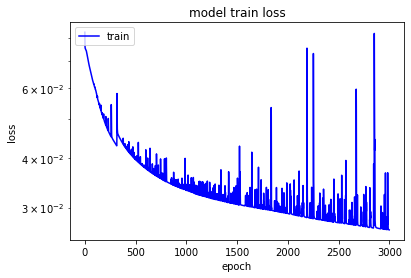

In [23]:
# summarize history for loss
plt.clf()
plt.plot(train_loss_arr, color='blue')
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'train_loss.png')

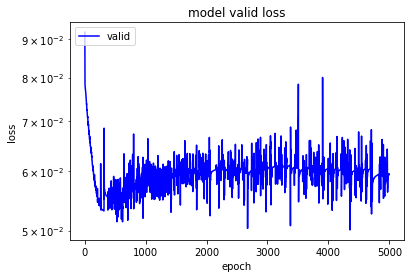

In [24]:
# summarize history for loss
plt.clf()
plt.plot(valid_loss_mean_arr, color='blue')
plt.title('model valid loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valid'], loc='upper left')
plt.yscale('log')
plt.savefig(newpath + '/' + 'valid_loss_mean.png')

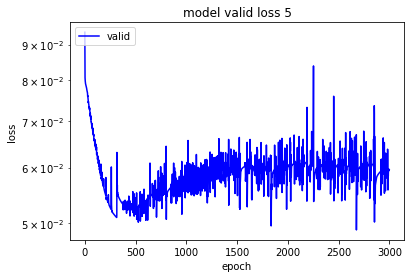

In [25]:
for seq in range(len(X_train)):
    # summarize history for loss
    plt.clf()
    plt.plot(valid_loss_arr[seq], color='blue')
    plt.title('model valid loss ' + str(seq))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['valid'], loc='upper left')
    plt.yscale('log')
    plt.savefig(newpath + '/' + f'valid_loss_{seq}.png')
